In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision   
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import time
import torch.optim as optim
import os
import gdown
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
!pwd

Wed May 12 03:07:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda, device, torch.cuda.device_count())

True cuda 1


In [ ]:
#!mkdir /content/data/
#!cp /content/drive/MyDrive/11785\ Project\ Group/unique_data/unique-142p.zip /content/

In [ ]:
!unzip /content/unique-142p.zip

In [ ]:
!mkdir /content/data/

In [ ]:
!mv /content/unique-142p/ /content/data/

In [ ]:
!ls /content/data/unique-142p/

## Model

In [ ]:
class MyBetaVAE(nn.Module):
    def __init__(self, in_channels, z_dim, beta): # image should have size 64*64
        super(MyBetaVAE, self).__init__()
        self.z_dim = z_dim
        self.beta = beta

        # hidden_dims = [in_channels, 32, 64, 128, 256, 512]
        hidden_dims = [in_channels, 32, 64, 128, 256]
        self.encoder_final_size = 16
        self.hidden_dims = hidden_dims

        # encoder
        encoder_layers = []
        for i in range(len(hidden_dims)-1):
            encoder_layers.append(nn.Sequential(
                                        nn.Conv2d(hidden_dims[i], hidden_dims[i+1], kernel_size=3, stride=2, padding=1),
                                        nn.BatchNorm2d(hidden_dims[i+1]),
                                        nn.LeakyReLU()
                                  ))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.mu = nn.Linear(hidden_dims[-1] * self.encoder_final_size, z_dim)
        self.logvar = nn.Linear(hidden_dims[-1] * self.encoder_final_size, z_dim)

        # decoder
        self.decoder_in = nn.Linear(z_dim, hidden_dims[-1] * self.encoder_final_size)

        decoder_layers = []
        for i in range(len(hidden_dims)-1, 0, -1):
            decoder_layers.append(nn.Sequential(
                                      nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i] if i == 1 else hidden_dims[i-1], kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.BatchNorm2d(hidden_dims[i] if i == 1 else hidden_dims[i-1]),
                                      nn.LeakyReLU()
                                  ))
        
        self.decoder = nn.Sequential(*decoder_layers,
                                     nn.Conv2d(hidden_dims[1], hidden_dims[0], kernel_size=3, padding=1),
                                     nn.Sigmoid())
    
    def encode(self, x):
        out = self.encoder(x)
        out = torch.flatten(out, start_dim=1)
        mu = self.mu(out)
        logvar = self.logvar(out)
        self.mu_value = mu
        self.logvar_value = logvar
        self.x = x
        return mu, logvar
    
    def decode(self, x):
        out = self.decoder_in(x).view(-1, self.hidden_dims[-1], 4, 4)
        out = self.decoder(out)
        return out
    
    def reparam(self, mu, logvar):
        std = torch.exp(logvar / 2)
        epsilon = torch.autograd.Variable(torch.randn_like(std))
        return std * epsilon + mu


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        out = self.decode(z)
        self.x_cons = out
        return out, z
    
    def loss(self):
        reconstruction_loss = F.mse_loss(self.x_cons, self.x, reduction='sum')
        kl_div = torch.mean(torch.sum(-0.5 * (1 + self.logvar_value - self.mu_value ** 2 - self.logvar_value.exp()), dim=1), dim=0)
        return reconstruction_loss + self.beta * kl_div, reconstruction_loss, kl_div

In [ ]:
in_channels, z_dim, beta = 3, 128, 0.5
model = MyBetaVAE(in_channels, z_dim, beta)
model = model.to(device)
print(model, next(model.parameters()).is_cuda)

In [ ]:
learningRate = 0.0005
weightDecay = 0.0
epochs = 140
gamma = 0.95
torch.manual_seed(42)
np.random.seed(11785)

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=gamma, verbose=True)

Adjusting learning rate of group 0 to 5.0000e-04.


## DataLoader

In [ ]:
!ls /content/data

unique-142p


In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()                                             
])

def get_dataloaders(path, shuffle, portion, val_split, batch_size, test=False):
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transforms)
    if test:
      test_dataset = torchvision.datasets.ImageFolder(root=path, transform=test_transforms)
      for filename in test_dataset.imgs:
          frame_names.append(filename[0].split('/')[-1])

    shuffle_dataset = shuffle
    use_proportion = portion
    validation_split = val_split
    batch_size = batch_size
    random_seed= 42

    # Creating data indices for training and validation splits:
    indices = list(range(len(dataset)))
    use_length = int(len(dataset) * use_proportion)
    split = int(np.floor((1 - validation_split) * len(dataset)) * use_proportion)
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[:split]
    print(train_indices)
    val_indices = indices[split:use_length]
    print(len(train_indices), len(val_indices))
    print(len(dataset), use_length, split)

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
  

    train_dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True,sampler=train_sampler)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True,sampler=val_sampler)

    if test:
      test_sampler = SequentialSampler(train_indices)
      test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, sampler=test_sampler)
      return test_dataloader, test_dataloader
    

    return train_dataloader, val_dataloader

In [ ]:
train_loader, val_loader= get_dataloaders('/content/data', shuffle=True, portion=1.0, val_split=0.2, batch_size=256)

## Train

In [ ]:
!mkdir /content/drive/MyDrive/beta_model/
!mkdir /content/drive/MyDrive/beta_loss/

In [ ]:
from tqdm.notebook import tqdm
def train(model, train_loader, val_loader, epochs):
    model.train()
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        avg_loss = 0.0
        for batch_num, (x,y) in enumerate(tqdm(train_loader, position=0, leave=True)):
            x = x.to(device)
            
            optimizer.zero_grad()

            recons_x, z = model(x)
            loss, mse, kld = model.loss()

            with open('/content/drive/MyDrive/train_loss.txt', 'a') as ft:
                ft.write('%f\n' % loss.item())
            with open('/content/drive/MyDrive/train_mse_loss.txt', 'a') as ft1:
                ft1.write('%f\n' % mse.item())
            with open('/content/drive/MyDrive/train_kld_loss.txt', 'a') as ft2:
                ft2.write('%f\n' % kld.item())
            
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            

            if batch_num % 200 == 199:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/200))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del x
            del recons_x
            del z
            del loss
            del mse
            del kld
            torch.cuda.empty_cache()

        end_time = time.time()
        print(end_time - start_time)
        val_loss = val(model, val_loader)
        # scheduler.step(val_loss)
        scheduler.step()
        if val_loss < best_loss:
            best_loss = val_loss
            checkpoint = {"model": model.state_dict(), 
                          "optimizer": optimizer.state_dict(),
                          "scheduler": scheduler.state_dict()}
            torch.save(checkpoint, '/content/drive/MyDrive/beta_model/v2_best_checkpoint_epoch'+str(epoch)+'.pt')
        if epoch % 10 == 0:
            checkpoint = {"model": model.state_dict(), 
                          "optimizer": optimizer.state_dict(),
                          "scheduler": scheduler.state_dict()}
            torch.save(checkpoint, '/content/drive/MyDrive/beta_model/v2_checkpoint_epoch'+str(epoch)+'.pt')
        print('Val Loss: {:.4f}'.format(val_loss))
        print('lr: ', optimizer.param_groups[0]['lr'])


def val(model, loader):
    model.eval()
    avg_loss = 0.0
    avg_mse = 0.0
    avg_kld = 0.0

    with torch.no_grad():
        for batch_num, (x,y) in enumerate(tqdm(loader, position=0, leave=True)):
            x = x.to(device)
            _, _ = model(x)
            loss, mse, kld = model.loss()

            avg_loss += loss.item()  
            avg_mse += mse.item()
            avg_kld += kld.item()
            
            torch.cuda.empty_cache()
            del x
            del loss
            del mse
            del kld
            torch.cuda.empty_cache()

    model.train()
    avg_loss = avg_loss / len(loader)
    avg_mse = avg_mse / len(loader)
    avg_kld = avg_kld / len(loader)
    with open('/content/drive/MyDrive/beta_loss/val_loss.txt', 'a') as fv:
        fv.write('%f\n' % avg_loss)
    with open('/content/drive/MyDrive/beta_loss/val_mse_loss.txt', 'a') as fv1:
        fv1.write('%f\n' % avg_mse)
    with open('/content/drive/MyDrive/beta_loss/val_kld_loss.txt', 'a') as fv2:
        fv2.write('%f\n' % avg_kld)

    return avg_loss

In [ ]:
train(model, train_loader, val_loader, epochs)

In [ ]:
torch.save(train_loader, '/content/drive/MyDrive/11785-HW/Project/v1/models/train_loader.pth')

In [ ]:
torch.save(val_loader, '/content/drive/MyDrive/11785-HW/Project/v1/models/val_loader.pth')

In [ ]:
from PIL import Image
img = Image.open('/content/data/knnw-720p/frame_30333.jpeg')

In [ ]:
transforms(img).shape

## Inference & Accuracy

In [ ]:
!mkdir /content/dev_data/
!cp /content/drive/MyDrive/11785\ Project\ Group/unique_data/unique-142p-dev.zip /content/

In [ ]:
!unzip /content/unique-142p-dev.zip
!mv /content/unique-142p-valid /content/dev_data

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

logs = {}
avg_loss = 0
z_ls = []

# TODO
frame_names = []
dev_loader, dev_original_loader = get_dataloaders('/content/data', shuffle=False, portion=1, val_split=0, batch_size=1, test=True)
print(frame_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
x_ls = []
i = 0
for (x,y) in dev_original_loader:
  i += 1
  x = x.to(device)
  x_ls.append(x)

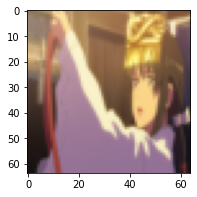

In [ ]:
#12199 2338
fig = plt.figure(figsize=(3, 3))
plt.imshow((x_ls[12199][0]*255).permute(1,2,0).detach().cpu().numpy().astype(np.uint8))
plt.show()

In [ ]:
for batch_num, (x,y) in enumerate(dev_original_loader):
  print(batch_num)
  plt.imshow((x[0]*255).permute(1,2,0).detach().cpu().numpy().astype(np.uint8))
  plt.show()
  #if batch_num > 30:
  #  break

In [ ]:
# change path and beta!
checkpoint = torch.load('/content/drive/MyDrive/11785 Project Group/v2/beta0.5/v2_best_checkpoint_epoch125.pt')
in_channels, z_dim, beta = 3, 128, 0.5
model = MyBetaVAE(in_channels, z_dim, beta)
model.load_state_dict(state_dict=checkpoint['model'])
model.to(device)

In [ ]:
out_imgs = []
z_ls = []
total = []
recon = []
klds = []
avg_loss = 0

with torch.no_grad():
    for batch_num, (x, y) in tqdm(enumerate(dev_loader)):
        x = x.to(device)
        out, z = model(x)

        out_imgs.append(out)
        z_ls.append(z)
        #x_ls.append(x)

        total_loss, reconstruct, kld = model.loss()
        total.append(total_loss.item())
        recon.append(reconstruct.item())
        klds.append(kld.item())
        avg_loss += total_loss.item()  
        


In [ ]:
def check_img_list(start, end, out_imgs, x=False):
  # create figure
  fig = plt.figure(figsize=(10, 7))
    
  # setting values to rows and column variables
  rows = 3
  columns = 4
  index = 1
  for i in range(start, end, 1):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, index)
    index+=1
      
    # showing image
    if x:
      plt.imshow(out_imgs[i][0].permute(1,2,0).cpu())
    else:
      plt.imshow(out_imgs[i][0].permute(1,2,0).cpu().data.numpy())
    plt.axis('off')
    plt.title("Output image "+str(i))
  plt.show()
  
def check_metrics(start, end, L0, L1, L2, cos_similarity):
  x = range(start, end-1)
  fig = plt.figure(figsize=(24, 4))
 
  plt.subplot(1,4,1)
  plt.plot(x, L0[start:end-1], 'r', label="L0")
  plt.legend(loc='best')
  plt.title("Evaluation "+ str(start)+" to "+str(end-1))

  plt.subplot(1,4,2)
  plt.plot(x, L1[start:end-1], 'g', label="L1")
  plt.legend(loc='best')
  #plt.title("Similarity Evaluation "+ str(start)+" to "+str(end)+" L1")

  plt.subplot(1,4,3)
  plt.plot(x, L2[start:end-1], 'm', label="L2")
  plt.legend(loc='best')
  #plt.title("Similarity Evaluation "+ str(start)+" to "+str(end)+" L2")

  plt.subplot(1,4,4)
  plt.ylim((0, 1))
  plt.plot(x, cos_similarity[start:end-1], 'c', label="cos_similarity")
  plt.legend(loc='best')
  #plt.title("Similarity Evaluation "+ str(start)+" to "+str(end)+" cos")

  
  plt.show()

In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# model.load_state_dict(torch.load("/content/drive/MyDrive/checkpoint.pt"))
model.eval()
size = len(dev_loader)
min_L0, max_L0 = 0, 0
min_L1, max_L1 = 0, 0
min_L2, max_L2 = 0, 0
min_cos, max_cos = 0, 0

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

out_L0 = []
out_L1 = []
out_L2 = []
out_cos_similarity = []
x_L0 = []
x_L1 = []
x_L2 = []
x_cos_similarity = []
z_L0 = []
z_L1 = []
z_L2 = []
z_cos_similarity = []

out_imgs = []
z_ls = []


with torch.no_grad():
    for batch_num, (x, y) in tqdm(enumerate(dev_loader)):
        x = x.to(device)
        out, z = model(x)

        out_imgs.append(out)
        z_ls.append(z)
        #x_ls.append(x)

        loss, mse, kld = model.loss()
        avg_loss += loss.item()  
        
        torch.cuda.empty_cache()
        del x
        del loss
        torch.cuda.empty_cache()

In [ ]:
for i in range(len(dev_loader) - 1):
    # L0 for out, x, z
    metric = torch.norm(out_imgs[i]-out_imgs[i+1], 0)
    out_L0.append(metric.item())
    metric = torch.norm(z_ls[i]-z_ls[i+1], 0)
    z_L0.append(metric.item())
    metric = torch.norm(x_ls[i]-x_ls[i+1], 0)
    x_L0.append(metric.item())

    # L1 for out, x, z
    metric = torch.norm(out_imgs[i]-out_imgs[i+1], 1)
    out_L1.append(metric.item())
    metric = torch.norm(z_ls[i]-z_ls[i+1], 1)
    z_L1.append(metric.item())
    metric = torch.norm(x_ls[i]-x_ls[i+1], 1)
    x_L1.append(metric.item())

    # L2 for out, x, z
    metric = torch.norm(out_imgs[i]-out_imgs[i+1], 2)
    out_L2.append(metric.item())
    metric = torch.norm(z_ls[i]-z_ls[i+1], 2)
    z_L2.append(metric.item())
    metric = torch.norm(x_ls[i]-x_ls[i+1], 2)
    x_L2.append(metric.item())

    # cos for out, x, z
    metric = cos(z_ls[i], z_ls[i+1])
    z_cos_similarity.append(metric.item())
    #print(out_imgs[i].flatten().shape)
    metric = cos(out_imgs[i].flatten().unsqueeze(0), out_imgs[i+1].flatten().unsqueeze(0))
    out_cos_similarity.append(metric.item())
    metric = cos(x_ls[i].flatten().unsqueeze(0), x_ls[i+1].flatten().unsqueeze(0))
    x_cos_similarity.append(metric.item())

    if i != 0 and i % 1200 ==0:
      print("Check "+str(i-12)+" to "+str(i))
      check_img_list(i-12, i, out_imgs)
      check_metrics(i-12, i, out_L0, out_L1, out_L2, out_cos_similarity)  # check output
      check_metrics(i-12, i, z_L0, z_L1, z_L2, z_cos_similarity)  # check z
      check_img_list(i-12, i, x_ls, x=True)
      check_metrics(i-12, i, x_L0, x_L1, x_L2, x_cos_similarity)
    

min_L0, max_L0 = min(out_L0), max(out_L0)
min_L1, max_L1 = min(out_L1), max(out_L1)
min_L2, max_L2 = min(out_L2), max(out_L2)
min_cos, max_cos = min(out_cos_similarity), max(out_cos_similarity)

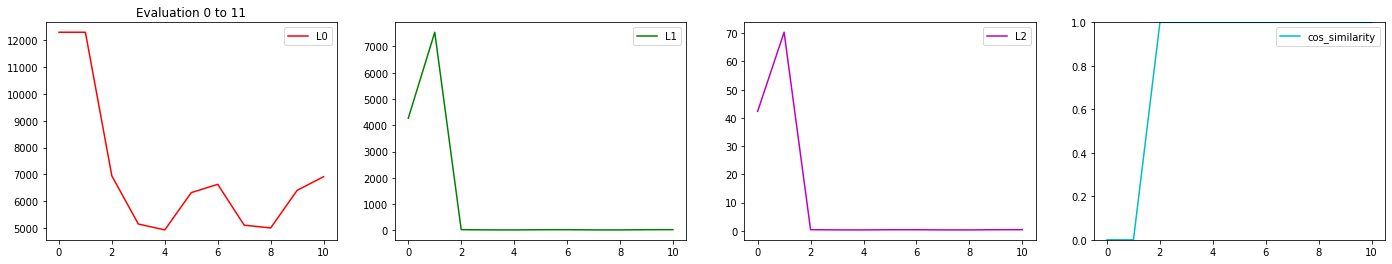

In [ ]:
check_metrics(0, 12, x_L0, x_L1, x_L2, x_cos_similarity)

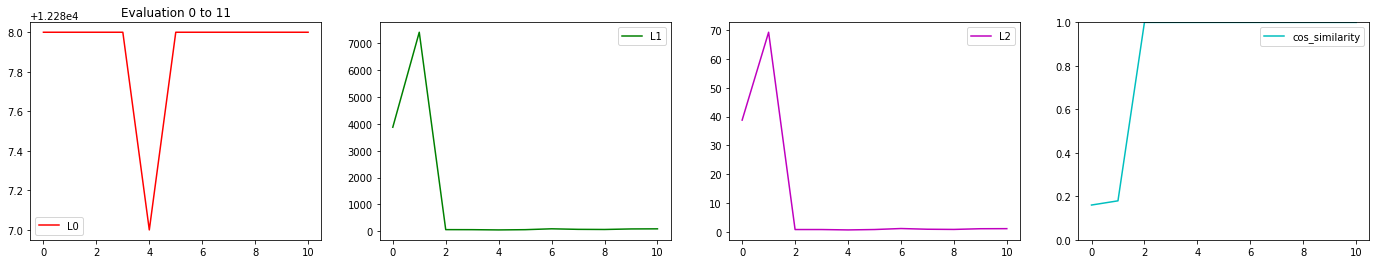

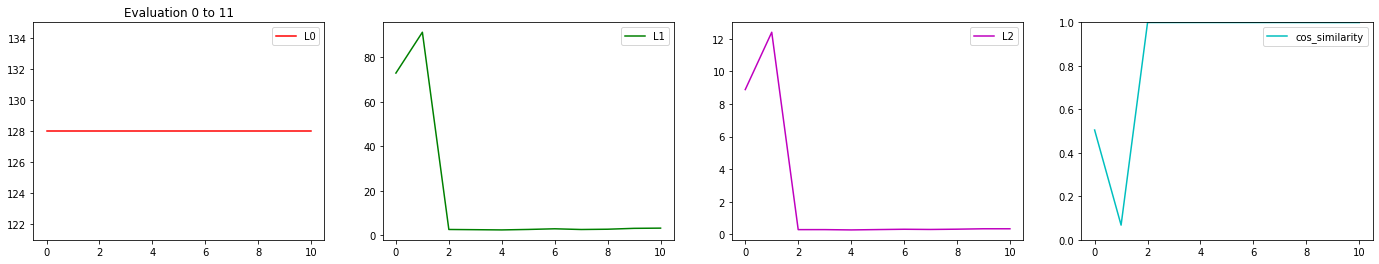

In [ ]:
check_metrics(0, 12, out_L0, out_L1, out_L2, out_cos_similarity)
check_metrics(0, 12, z_L0, z_L1, z_L2, z_cos_similarity)

In [ ]:
import numpy as np
labels = np.genfromtxt('/content/drive/MyDrive/11785 Project Group/data/scene-change.csv', delimiter=',', names=True, dtype=None, encoding=None)

In [ ]:
len(labels)

259

In [ ]:
label_ls = [] # record frame1 in true_labels
for labels in labels:
  label_ls.append(labels[0])
print(label_ls[:10])

['frame_001278.png', 'frame_001279.png', 'frame_001499.png', 'frame_001607.png', 'frame_001617.png', 'frame_001690.png', 'frame_001743.png', 'frame_001802.png', 'frame_001839.png', 'frame_001867.png']


In [ ]:
# frame_names
# label_ls
true_labels = []
for name in frame_names:
    if name in label_ls:
        true_labels.append(1)
    else:
        true_labels.append(0)
print(len(true_labels))

12937


In [ ]:
# z_cos_similarity
# x_cos_similarity
# out_cos_similarity
threshold = 0.75 # scene change threshold
size = len(dev_loader)
change_pred = []
correct_cnt1 = 0

for i in range(size - 1):
    # the similarity between ith and (i+1)th
    if z_cos_similarity[i] < threshold:
        change_pred.append(frame_names[i]) # append the filename of the first frame
        if frame_names[i] in label_ls:
            correct_cnt1 += 1


# accuracy rate
acc_rate1 = correct_cnt1 / len(label_ls) # TODO


correct_cnt2 = 0
for i in range(size - 1):
    if z_cos_similarity[i] < threshold:
        if frame_names[i] in label_ls:
            correct_cnt2 += 1
    else:
        if frame_names[i] not in label_ls:
            correct_cnt2 += 1
acc_rate2 = correct_cnt2 / (size - 1)

print(acc_rate1, acc_rate2)
print(change_pred)
print(len(change_pred), len(label_ls))

0.8996138996138996 0.989100185528757
['frame_001278.png', 'frame_001279.png', 'frame_001499.png', 'frame_001607.png', 'frame_001617.png', 'frame_001690.png', 'frame_001743.png', 'frame_001802.png', 'frame_001839.png', 'frame_001867.png', 'frame_001916.png', 'frame_001951.png', 'frame_002029.png', 'frame_002116.png', 'frame_002179.png', 'frame_002254.png', 'frame_002255.png', 'frame_002379.png', 'frame_002491.png', 'frame_002770.png', 'frame_002912.png', 'frame_003042.png', 'frame_003117.png', 'frame_003395.png', 'frame_003399.png', 'frame_003401.png', 'frame_003402.png', 'frame_003403.png', 'frame_003404.png', 'frame_003405.png', 'frame_003410.png', 'frame_003413.png', 'frame_003416.png', 'frame_003467.png', 'frame_003536.png', 'frame_003551.png', 'frame_003568.png', 'frame_003584.png', 'frame_003600.png', 'frame_003670.png', 'frame_003699.png', 'frame_003719.png', 'frame_003731.png', 'frame_003758.png', 'frame_003759.png', 'frame_003760.png', 'frame_003761.png', 'frame_003764.png', 'f

## Plot Top 5 Loss

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

frame_names = []
dev_loader, dev_original_loader = get_dataloaders('/content/data', shuffle=False, portion=1, val_split=0, batch_size=1, test=True)
print(frame_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
# change path and beta!
checkpoint = torch.load('/content/drive/MyDrive/11785 Project Group/v2/beta0.5/v2_best_checkpoint_epoch125.pt')
in_channels, z_dim, beta = 3, 128, 0.5
model = MyBetaVAE(in_channels, z_dim, beta)
model.load_state_dict(state_dict=checkpoint['model'])
model.to(device)

In [ ]:
x_ls = []
i = 0
for (x,y) in dev_original_loader:
  i += 1
  x = x.to(device)
  x_ls.append(x)

In [ ]:
out_imgs = []
z_ls = []
total = []
recon = []
klds = []
avg_loss = 0

with torch.no_grad():
    for batch_num, (x, y) in tqdm(enumerate(dev_loader)):
        x = x.to(device)
        out, z = model(x)

        out_imgs.append(out)
        z_ls.append(z)
        #x_ls.append(x)

        total_loss, reconstruct, kld = model.loss()
        total.append(total_loss.item())
        recon.append(reconstruct.item())
        klds.append(kld.item())
        avg_loss += total_loss.item()  
        
        torch.cuda.empty_cache()
        del x
        torch.cuda.empty_cache()

In [ ]:
total = np.asarray(total)
recon = np.asarray(recon)
klds = np.asarray(klds)
cnt = len(total)

total_sort = np.argsort(-total)
recon_sort = np.argsort(-recon)
kld_sort = np.argsort(-klds)

high5_total = total_sort[:5]
high5_recon = recon_sort[:5]
high5_kld = kld_sort[:5]

low5_total = total_sort[cnt-5:cnt]
low5_recon = recon_sort[cnt-5:cnt]
low5_kld = kld_sort[cnt-5:cnt]


In [ ]:
mean_total = np.mean(total)
mean_recon = np.mean(recon)
mean_kld = np.mean(klds)
print(mean_total, mean_recon, mean_kld)

2149.7094711613613 1735.6759791954462 828.0669844867774


In [ ]:
mean_total_id = np.where(np.logical_and(total>mean_total-0.05, total<mean_total+0.02))[0]
mean_recon_id = np.where(np.logical_and(recon>mean_recon-0.04, recon<mean_recon+0.03))[0]
mean_kld_id = np.where(np.logical_and(klds>mean_kld-0.005, klds<mean_kld+0.004))[0]
print(mean_total_id, mean_recon_id, mean_kld_id)

[ 7767 35465 45792 57843 68891] [ 8015 10687 37042 44148 63574] [ 2338 23884 25944 60363 72809]


In [ ]:
def plot_top_5(indices, images):
  # create figure
  fig = plt.figure(figsize=(13, 12))
  # setting values to rows and column variables
  rows = 1
  columns = 5
  index = 1
  for i in indices:
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, index)
    index+=1
      
    # showing image
    plt.imshow(images[i][0].permute(1,2,0).cpu())
    plt.axis('off')

    plt.title("Image "+str(i))

  #fig.suptitle('', fontsize=10)
  plt.show()

In [ ]:
print(high5_total, high5_recon, high5_kld)

[59185  4506 59184  4505  3432] [59185  4506 59184  4505  3432] [ 5273 34377 34376  5274 23825]


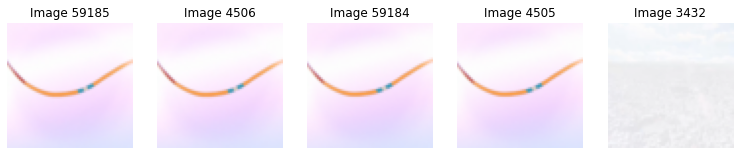

In [ ]:
plot_top_5(high5_total, x_ls)

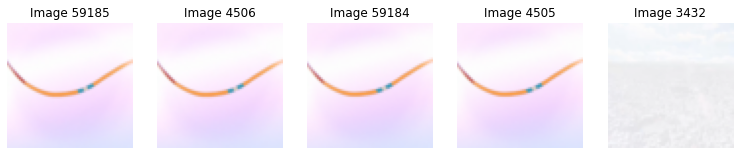

In [ ]:
plot_top_5(high5_recon, x_ls)

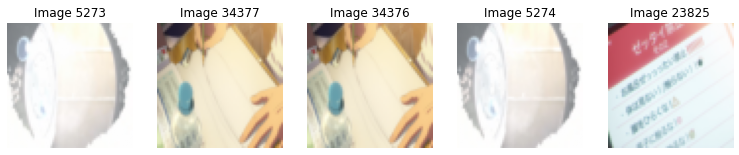

In [ ]:
plot_top_5(high5_kld, x_ls)

In [ ]:
print(low5_total, low5_recon, low5_kld)

[29634 29632 29635 29631 29633] [29634 29632 29635 29631 29633] [80838 80837 80833 80835 80836]


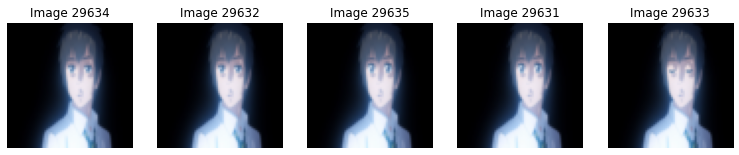

In [ ]:
plot_top_5(low5_total, x_ls)

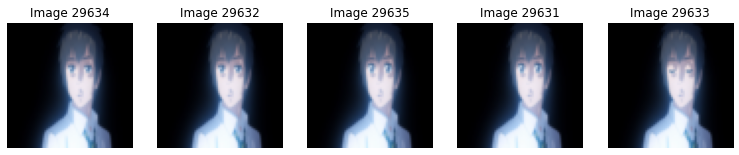

In [ ]:
plot_top_5(low5_recon, x_ls)

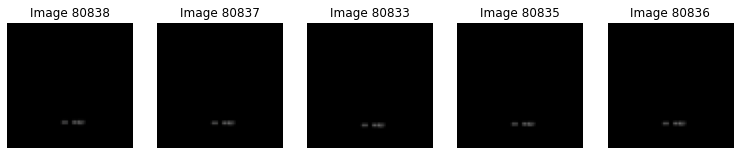

In [ ]:
plot_top_5(low5_kld, x_ls)

In [ ]:
print(mean_total_id, mean_recon_id, mean_kld_id)

[ 7767 35465 45792 57843 68891] [ 8015 10687 37042 44148 63574] [ 2338 23884 25944 60363 72809]


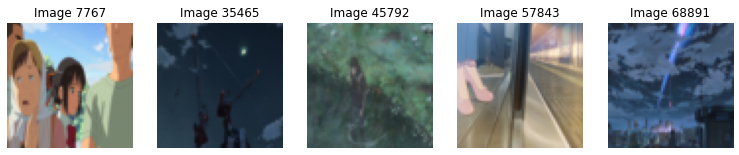

In [ ]:
plot_top_5(mean_total_id.tolist(), x_ls)

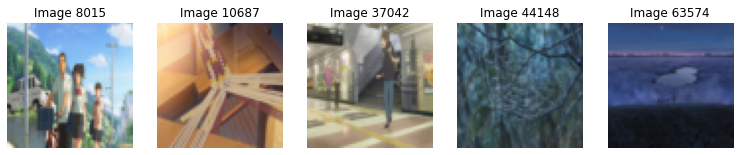

In [ ]:
plot_top_5(mean_recon_id.tolist(), x_ls)

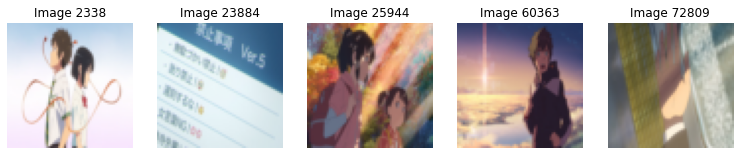

In [ ]:
plot_top_5(mean_kld_id.tolist(), x_ls)